# 🔎 Dataset Description
El objetivo de esta competición es detectar y traducir el lenguaje de señas americano (ASL) a texto.

Esta competencia requiere que las presentaciones se realicen en forma de modelos de TensorFlow Lite. Puedes entrenar tu modelo utilizando el marco de trabajo de tu elección siempre que conviertas el punto de control del modelo al formato tflite antes de la presentación. Consulta la página de evaluación para obtener más detalles.

# 📄 Files

## [train/supplemental_metadata].csv

* `path` - La ruta al archivo de referencia.
* `file_id` - Un identificador único para el archivo de datos.
* `participant_id` - Un identificador único para el contribuyente de datos.
* `sequence_id` - Un identificador único para la secuencia de referencia. Cada archivo de datos puede contener muchas secuencias.
* `phrase` - Las etiquetas para la secuencia de referencia. Los conjuntos de datos de entrenamiento y prueba contienen **direcciones, números de teléfono y URL generados al azar, derivados de componentes de direcciones reales/números de teléfono/URL**. Cualquier coincidencia con direcciones reales, números de teléfono o URL es puramente accidental. **El conjunto de datos complementario consiste en oraciones deletreadas con los dedos**. Ten en cuenta que algunas de las URL incluyen contenido para adultos. El objetivo de esta competencia es apoyar a la comunidad de personas sordas y con discapacidad auditiva para que se involucren con la tecnología en igualdad de condiciones con otros adultos.

## character_to_prediction_index.json

Un diccionario en el que se asigna a distintos simbolos un número entero.

## [train/supplemental]_landmarks/

Los datos de referencia. Los puntos de referencia se extrajeron de videos en bruto con el modelo de MediaPipe. **No todos los fotogramas necesariamente tenían manos visibles o manos que pudieran ser detectadas por el modelo**.
Los archivos de referencia contienen los mismos datos que en la competición de ASL Signs (excepto la columna de ID de fila) pero con una estructura amplia. **Esto te permite aprovechar el formato Parquet para omitir por completo la carga de puntos de referencia que no estás utilizando**.

* `sequence_id` - Un identificador único para la secuencia de referencia. Los archivos de referencia contienen aproximadamente 1,000 secuencias. El ID de secuencia se utiliza como índice del dataframe.
* `frame` - El número de fotograma dentro de una secuencia de referencia.
* `[x/y/z]_[type]_[landmark_index]` - Ahora hay 1,629 columnas de coordenadas espaciales para las coordenadas x, y y z de cada uno de los 543 puntos de referencia. El tipo de punto de referencia puede ser uno de `['face', 'left_hand', 'pose', 'right_hand']`. Aquí se pueden encontrar detalles sobre las ubicaciones de los puntos de referencia de las manos. Las coordenadas espaciales ya han sido normalizadas por MediaPipe. Ten en cuenta que el modelo de MediaPipe no está completamente entrenado para predecir la profundidad, por lo que es posible que desees ignorar los valores de z. Los puntos de referencia se han convertido a float32.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from pathlib import Path

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import re

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Character_to_prediction_index

Convertimos el diccionario en un dataframe de pandas

In [3]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

# convert dictionary to pandas dataframe
CHAR2ORD_DF = pd.DataFrame(CHAR2ORD.values(),index=CHAR2ORD.keys(),columns=['Ordinal Encoding'])
CHAR2ORD_DF.head()

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4


# Hyperparameters

Definimos los hiperparámetros que vamos a usar posteriormente

- `IS_INTERACTIVE`: Esta variable indica si el cuaderno se está ejecutando en modo interactivo, lo que significa que se está ejecutando en un entorno donde se pueden realizar cambios y experimentar de manera interactiva. En este modo, puedes ejecutar celdas de código individualmente, modificar el código y ver los resultados inmediatamente. Esto es útil cuando estás desarrollando y depurando tu código, ya que te permite realizar cambios rápidos y observar los efectos de esos cambios en tiempo real.

- `SEED`: Esta es una semilla aleatoria global utilizada para reproducir los resultados. Al fijar una semilla, se garantiza que los resultados sean consistentes en diferentes ejecuciones.

- `N_TARGET_FRAMES`: Esta variable indica el número de fotogramas a los que se redimensionarán las grabaciones. Esto se hace para **estandarizar la longitud de las secuencias de entrada**.

- `DEBUG`: Esta variable indica si se está ejecutando en modo de depuración. Si es `True`, se ejecutará en modo de depuración, lo que puede implicar la ejecución de un subconjunto de los datos para una ejecución más rápida y para facilitar la depuración.

- `N_UNIQUE_CHARACTERS0`: Esta variable representa el número de **caracteres únicos que se deben predecir en el modelo**. No incluye el token de padding (relleno), el token de inicio de oración y el token de fin de oración.

- `N_UNIQUE_CHARACTERS`: Esta variable es similar a `N_UNIQUE_CHARACTERS0`, pero incluye el token de relleno, el token de inicio de oración y el token de fin de oración. Por lo tanto, representa el número total de clases que el modelo debe predecir.

- `N_UNIQUE_CHARACTERSPAD_TOKEN`, `START_TOKEN` y `END_TOKEN`: Estas variables representan los índices de los tokens de padding, inicio de oración y fin de oración en el vocabulario. Se utilizan durante el procesamiento de los datos y la generación de las secuencias de texto objetivo.

In [4]:
# Number of Unique Characters
N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}') # ends in number 58

N_UNIQUE_CHARACTERS: 59


In [5]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Describe Statistics Percentiles
PERCENTILES = [0.01, 0.10, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False
# Fast Processing
FAST= False
# Number of Unique Characters To Predict + Pad Token + Start of sentence and end of sentence Token 
N_UNIQUE_CHARACTERSPAD_TOKEN = len(CHAR2ORD) # Padding = 59
START_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence = 60
END_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence = 61

# Data Preparation

In [6]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

train.head()

,path,file_id,sequence_id,participant_id,phrase,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...


Definimos la función `get_phrase_type`, que toma como entrada una frase (phrase):

- Primero, verifica si la frase consiste únicamente en dígitos, signos de más (+) o guiones (-) utilizando la expresión regex `re.match(r'^[\d+-]+$', phrase)`. Si la frase cumple con este patrón, se considera un "Phone Number" (número de teléfono).
- Si no se cumple la primera condición, la función verifica si la frase contiene alguna de las subcadenas `['www', '.', '/']` y no contiene espacios en blanco mediante la expresión `any([substr in phrase for substr in ['www', '.', '/']])` and `' ' not in phrase`. Si se cumple esta condición, se considera una "URL".
- Si ninguna de las dos condiciones anteriores se cumple, se asume que la frase es una "Address" (dirección).
- Finalmente, la función devuelve el indetificativo

In [7]:
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)

train.head(10)

,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address
5,train_landmarks/5414471.parquet,5414471,1817141095,38,www.freem.ne.jp,/kaggle/input/asl-fingerspelling/train_landmar...,url
6,train_landmarks/5414471.parquet,5414471,1817169529,70,https://jsi.is/hukuoka,/kaggle/input/asl-fingerspelling/train_landmar...,url
7,train_landmarks/5414471.parquet,5414471,1817171518,202,239613 stolze street,/kaggle/input/asl-fingerspelling/train_landmar...,address
8,train_landmarks/5414471.parquet,5414471,1817195757,136,242-197-6202,/kaggle/input/asl-fingerspelling/train_landmar...,phone_number
9,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard,/kaggle/input/asl-fingerspelling/train_landmar...,address


Extraemos de la frase los caracteres y la longitud de la frase

In [8]:
# Split Phrase To Char Tuple
train['phrase_char'] = train['phrase'].apply(tuple)
# Character Length of Phrase
train['phrase_char_len'] = train['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = train.set_index('sequence_id')

train.head()

MAX_PHRASE_LENGTH: 31


,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


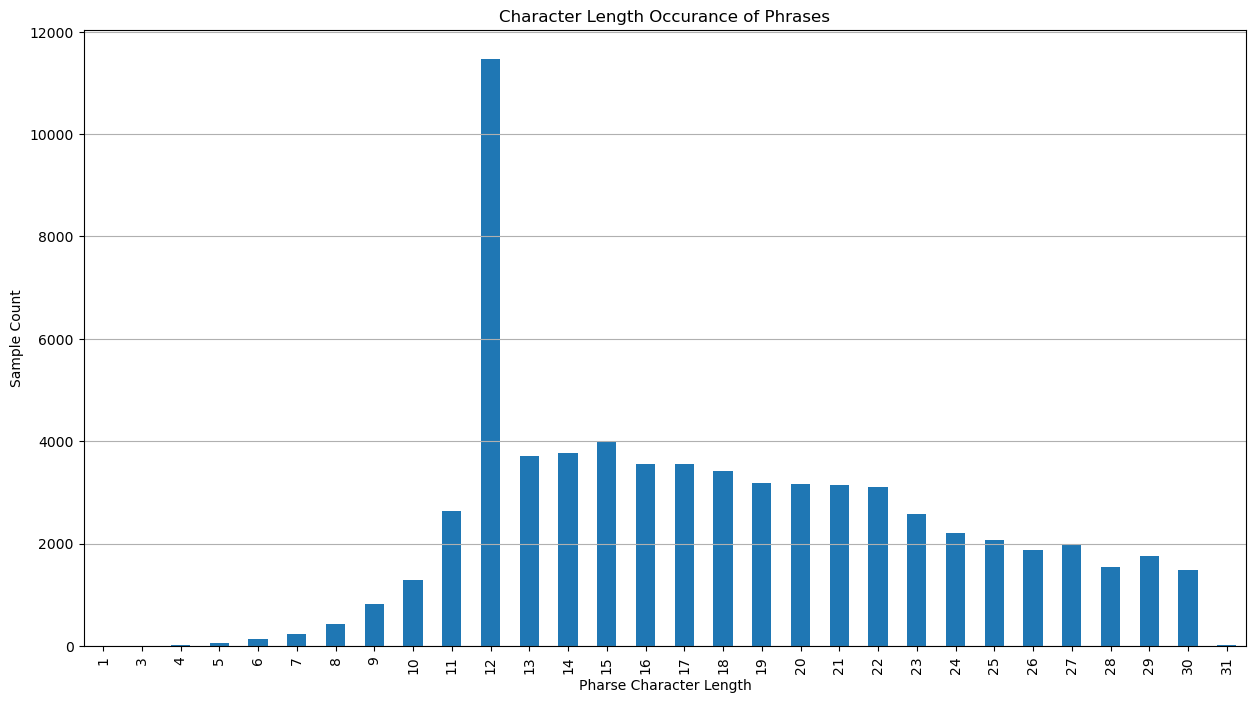

In [9]:
# Character Count Occurance
plt.figure(figsize=(15,8))
plt.title('Character Length Occurance of Phrases')
train['phrase_char_len'].value_counts().sort_index().plot(kind='bar')
plt.xlim(-0.50, train['phrase_char_len'].max() - 1.50)
plt.xlabel('Pharse Character Length')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

In [10]:
# Read First Parquet File
example_parquet_df = pd.read_parquet(train['file_path'][0])

# Each parquet file contains 1000 unique recordings
print(f'Number of Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
example_parquet_df.head()

Number of Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Define una variable `N` que indica el número de fragmentos de archivos Parquet que se analizarán. Si la variable IS_INTERACTIVE es True, se establece N en 5, de lo contrario, se establece en 25.
- Define una lista vacía `N_UNIQUE_FRAMES` que se utilizará para almacenar el número de frames únicos en cada grabación. 
- Crea una serie `UNIQUE_FILE_PATHS` que contiene las rutas únicas de los archivos del DataFrame train en la columna "file_path".
- Luego, se itera sobre una muestra aleatoria de N rutas de archivos obtenidas de UNIQUE_FILE_PATHS utilizando UNIQUE_FILE_PATHS.sample(N, random_state=SEED). Esto implica seleccionar aleatoriamente un subconjunto de rutas de archivo para analizar.
- Para cada ruta de archivo seleccionada, se lee el archivo Parquet correspondiente utilizando pd.read_parquet(file_path) y se almacena en el DataFrame df. A continuación, el DataFrame df se agrupa por el valor de la columna "sequence_id" utilizando groupby('sequence_id').
- Para cada grupo (grupo de secuencias con el mismo ID), se calcula el número de cuadros únicos en la columna "frame" utilizando group_df['frame'].nunique().El número de cuadros únicos obtenidos se agrega a la lista N_UNIQUE_FRAMES.

In [11]:
# Number of parquet chunks to analyse
N = 5 if IS_INTERACTIVE else 25
# Number of Unique Frames in Recording
N_UNIQUE_FRAMES = []

UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique()) # total file paths

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path) # read the parquet 
    for group, group_df in df.groupby('sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

  0%|          | 0/5 [00:00<?, ?it/s]

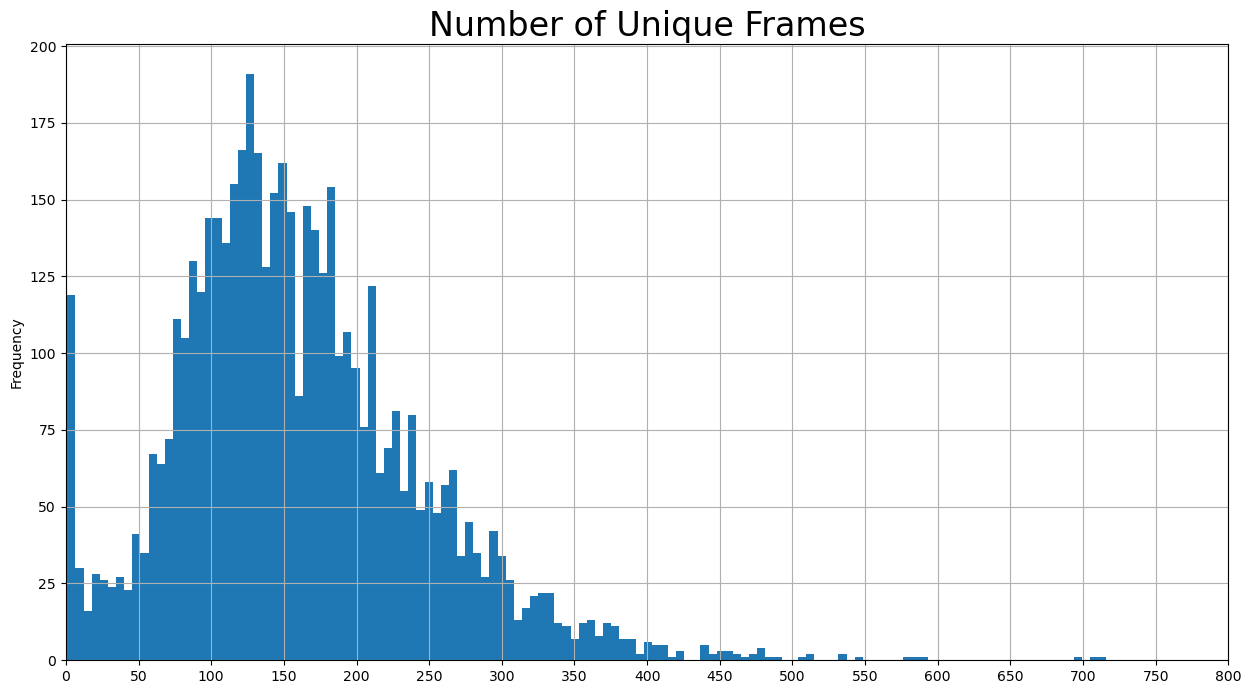

In [12]:
plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+50, 50))
plt.show()

Definimos la función `get_idxs`, recibe como entrada un DataFrame `df`, una lista de palabras clave `words_pos`, otra lista de palabras clave `words_neg` (opcional), un indicador booleano `ret_names` (indicando si se deben devolver los nombres de columna) y una lista de índices de columna positivos `idxs_pos` (opcional).

La función recorre el DataFrame `df` y busca columnas cuyos nombres cumplan ciertas condiciones. El objetivo es encontrar las columnas que contengan todas las palabras clave positivas y ninguna de las palabras clave negativas.

Para cada palabra clave positiva en `words_pos`, la función itera sobre las columnas del DataFrame. Si una columna no es una columna de landmark (como la columna "frame"), se omite y se pasa a la siguiente columna.

Luego, la función extrae el índice de columna de la columna actual y verifica si el nombre de la columna contiene la palabra clave positiva y ninguna de las palabras clave negativas. Si cumple con estas condiciones y, opcionalmente, si el índice de columna está en la lista `idxs_pos`, se agrega el índice de columna a la lista `idxs` y el nombre de la columna a la lista `names`.

Al final, la función convierte las listas `idxs` y `names` en arreglos de NumPy y las devuelve. Dependiendo del valor de `ret_names`, la función puede devolver solo los índices de columna o tanto los índices de columna como los nombres de columna.

In [13]:
def get_idxs(df, words_pos, words_neg=['z'], ret_names=True, idxs_pos=None):
    # words_pos is the first element we want to select : ['face','right_hand','left_hand','pose']
    # words_neg are the components we want to exclude: ['x','y','z']
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

Extraemos ahora los distintos índices de los parquets que nos interesan para resolver el problema. Nos quedaremos con los índices de las manos derecha e izquierda y los correspondientes a los labios, que son los que más información podrían aportarnos. Los índices de los labios los obtenemos de google ([lips landmarks](https://github.com/tensorflow/tfjs-models/blob/838611c02f51159afdd77469ce67f0e26b7bbb23/face-landmarks-detection/src/mediapipe-facemesh/keypoints.ts))

In [14]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [15]:
print(f' Indexes of the left hand: {LEFT_HAND_IDXS0.tolist()}')
print(f'\n Indexes of the lips: {LIPS_IDXS0.tolist()}')

 Indexes of the left hand: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

 Indexes of the lips: [0, 13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409, 415, 0, 13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409, 415]


Ahora, nos quedamos con las columnas del parquet que nos interesan, es decir, aquellas que contienen los índices de las manos derecha e izquierda y los labios:

- Se utiliza la función `np.isin()` para verificar qué columnas del array `COLUMNS0` están presentes en la lista `LEFT_HAND_NAMES0`. La función `np.argwhere()` se utiliza para obtener los índices de las columnas coincidentes. El resultado se asigna a la variable `LEFT_HAND_IDXS`. Este proceso se repite para las listas `RIGHT_HAND_NAMES0` y `LIPS_NAMES0`, y se obtienen los índices correspondientes de las columnas en `RIGHT_HAND_IDXS` y `LIPS_IDXS` respectivamente. Estos índices representan las ubicaciones de las columnas en el array `COLUMNS0`.

- La variable `N_COLS` se asigna con el valor de `N_COLS0`. Esto indica la cantidad total de columnas presentes en `COLUMNS0`.

- La variable `N_DIMS` se establece en 2. Esto indica que solo se utilizarán los ejes X e Y de las coordenadas de los landmarks.

In [16]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
# obtain indices of the LEFT_HAND_NAMES0 in COLUMNS0
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
N_COLS = N_COLS0
# Only x and y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


Creamos arrays de índices y nombres de columnas específicos para las coordenadas X e Y de la mano izquierda en un conjunto de datos procesados. Esto puede ser útil para acceder y manipular los datos de estas coordenadas de manera más conveniente.

In [17]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

# Preprocessing

Ahora, comenzamos con el preprocesamiento, y definimos una capa personalizada de preprocesamiento llamada `PreprocessLayerNonNaN`. La clase hereda de `tf.keras.layers.Layer`, lo que la convierte en una capa de Keras. En el constructor `__init__`, no se realiza ninguna operación adicional.

El método `call` es el núcleo de la capa y se ejecuta cuando la capa se llama con datos de entrada. Está decorado con `@tf.function` y especifica una `input_signature` que indica la forma y el tipo de los datos de entrada. `@tf.function` es un decorador en TensorFlow que permite compilar y optimizar funciones de Python para su ejecución en gráficos computacionales. Al decorar una función con `@tf.function`, TensorFlow analiza el código de la función y crea un grafo computacional optimizado que se puede ejecutar de manera eficiente.

input_signature es un argumento de tf.function que se utiliza para especificar la firma de entrada de la función. En este caso, se utiliza `input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),)` para indicar que la función espera un único argumento de entrada que debe ser un tensor de tipo float32 con una forma de `[None, N_COLS0]`. El valor None en la forma del tensor indica que puede tener cualquier tamaño en esa dimensión.

Dentro del método `call`, se realiza el siguiente preprocesamiento:

- Se rellenan los valores NaN en los datos de entrada data0 con ceros utilizando la función `tf.where` y la condición `tf.math.is_nan(data0)`. Esto asegura que no haya valores NaN en los datos.
Se realiza una manipulación de la forma de los datos para agregar una dimensión adicional al principio. Esto se logra utilizando `data[None]`, lo que agrega una dimensión de tamaño 1 al inicio de los datos.
- Luego, se aplica un filtrado llamado "Empty Hand Frame Filtering" a los datos. Se extraen los frames de manos de los datos utilizando `tf.slice`. La línea `hands = tf.slice(data, [0,0,0], [-1, -1, 84])` selecciona una porción de los datos desde el inicio hasta el final en las dos primeras dimensiones y los primeros 84 elementos en la tercera dimensión.
- A continuación, se calcula el valor absoluto de los frames utilizando `tf.abs(hands)`. Esto se hace para asegurarse de que todos los valores sean positivos. Luego, se crea una máscara llamada mask al sumar los valores a lo largo del eje de los cuadros de mano utilizando `tf.reduce_sum(hands, axis=2)`. Después, se verifica si la suma es distinta de cero utilizando `tf.not_equal(mask, 0)`.
- La máscara se utiliza para seleccionar solo los cuadros de datos que contienen información de mano, y se asignan a data utilizando `data = data[mask][None]`. Esto filtra los cuadros de datos que no contienen información de mano.
- Finalmente, se realiza una manipulación adicional para eliminar la dimensión adicional agregada anteriormente utilizando `data = tf.squeeze(data, axis=[0])`. Se devuelve data, que representa los datos de entrada preprocesados.

In [18]:
class PreprocessLayerNonNaN(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayerNonNaN, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Add another dimension
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84]) # 84 its 21 x 4, left_hand, right_hand and x,y
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer_non_nan = PreprocessLayerNonNaN()

In [19]:
df = pd.read_parquet(file_path)
for group, group_df in df.groupby('sequence_id'):
    # extract sequence_id = group and the rest of the dataframe = group_df
    datagroup = group
    datagroupdf = group_df

display(datagroupdf[COLUMNS0].iloc[:,:84].head())
print('\n')
display(datagroup)

,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
197954332,0.795443,0.705655,0.636542,0.590708,0.549502,0.666559,0.600597,0.550668,0.504742,0.710195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197954332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197954332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197954332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197954332,0.850183,0.870682,0.851333,0.813897,0.795805,0.792695,0.730335,0.695488,0.670018,0.740282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


197954332

In [20]:
# Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
# Number of parquet chunks to analyse
N = 5 if (IS_INTERACTIVE or FAST) else len(UNIQUE_FILE_PATHS)
# Number of Non Nan Frames in Recording
N_NON_NAN_FRAMES = []

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        # group = sequence_id 
        # group_df = the rest of the dataframe (left_hand, right_hand,...)
        # preprocess the left hand and right hand values for that sequence id
        frames = preprocess_layer_non_nan(group_df[COLUMNS0].values).numpy()
        # append the number of frames that are not NaN
        N_NON_NAN_FRAMES.append(len(frames))

# Convert to Numpy Array
N_NON_NAN_FRAMES = pd.Series(N_NON_NAN_FRAMES).to_frame('# Frames')

  0%|          | 0/5 [00:00<?, ?it/s]

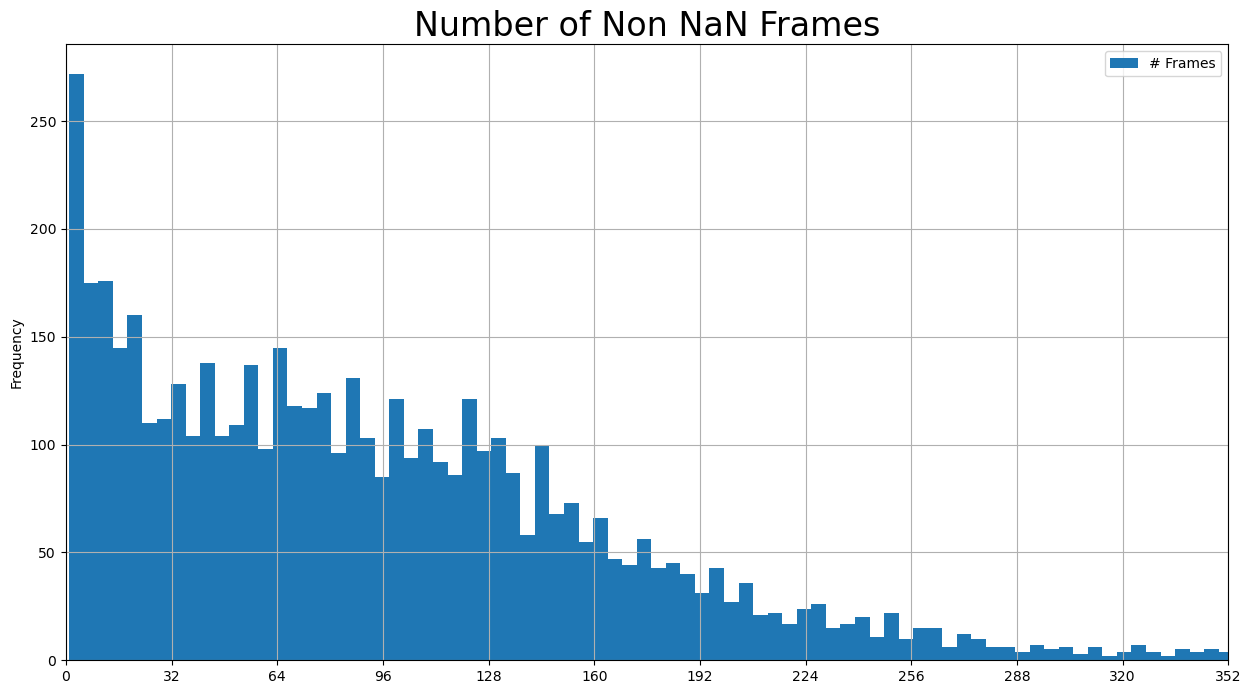

In [21]:
N_NON_NAN_FRAMES.plot(kind='hist', bins=128, figsize=(15,8))
plt.title('Number of Non NaN Frames', size=24)
plt.grid()
xlim = np.percentile(N_NON_NAN_FRAMES, 99)
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+32, 32))
plt.show()

Redefinimos la clase `PreprocessLayerNonNaN`, añadiendo la fase de relleno o padding:

- Calcula la longitud actual de los datos de entrada N_FRAMES utilizando `len(data[0])`.
- Compara la longitud actual de los datos `N_FRAMES` con una longitud objetivo `N_TARGET_FRAMES`. Si la longitud actual es menor que la longitud objetivo, se realiza el relleno con ceros.
- Se utiliza `tf.concat` para concatenar ceros adicionales al final de los datos y así alcanzar la longitud objetivo. Se crea un tensor de ceros utilizando `tf.zeros` con la forma `[1, N_TARGET_FRAMES-N_FRAMES, N_COLS]`, donde `N_COLS` representa la cantidad de columnas en los datos de entrada.
- Los ceros se concatenan a los datos utilizando `tf.concat((data, zeros), axis=1)`, donde `axis=1` indica que la concatenación se realiza a lo largo del eje de las columnas.

Después del relleno, se pasa a la siguiente etapa:

- El tensor data se redimensionará utilizando la función `tf.image.resize()` con un tamaño objetivo de `[1, N_TARGET_FRAMES]`, que en este caso es `[1,128]`. La función de redimensionamiento utilizará el método bilineal para ajustar el tamaño del tensor. Acabaremos con un tensor de la forma `[1,128,...]`.
- A continuación, se aplicará la función `tf.squeeze()` al tensor data con el argumento `axis=[0]`. Esto eliminará la dimensión de lote (1), lo que resultará en un tensor de tamaño `[128, ...]`.


In [22]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Add another dimension
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Padding with Zeros
        N_FRAMES = len(data[0]) # set N_FRAMES as the original length of the data
        if N_FRAMES < N_TARGET_FRAMES: 
            # N_TARGET_FRAMES = 128
            # then we use padding 
            data = tf.concat((
                data,    
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES], # [1,128]
            method=tf.image.ResizeMethod.BILINEAR,)
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

inputs = group_df[COLUMNS0].values # 164 columns (left_hand,right_hand,face) 
# dimension -> [n_rows, n_columns = 164]
print(inputs.shape) 
inputs = inputs[:1] # select the first row for the 164 columns
# dimension -> [1, 164]
print(inputs.shape)

frames = preprocess_layer(inputs) # Use PreprocessLayer in the example parquet

print(f'inputs shape: {inputs.shape}, NaN count: {np.isnan(inputs).sum()}')
print(f'frames shape: {frames.shape}, NaN count: {np.isnan(frames).sum()}')

(11, 164)
(1, 164)
inputs shape: (1, 164), NaN count: 42
frames shape: (128, 164), NaN count: 0


Como podemos ver, pasamos de un objeto tipo array de 164 valores (1 valor para cada columna) y 42 valores NaN ($\approx 25 \%$ de nulos) a un array  que ha sido rellenado 

Probemos a realizar el proceso manualmente para poder visualizarlo mejor:

In [23]:
''' define data to preprocess'''
inputs = group_df[COLUMNS0].values # 164 columns (left_hand,right_hand,face) 
# dimension -> [n_rows, n_columns = 164]
print(inputs.shape) 
inputs = inputs[:1] # select the first row for the 164 columns
# dimension -> [1, 164]
print(inputs.shape)

(11, 164)
(1, 164)


In [24]:
# Fill NaN Values With 0
data = tf.where(tf.math.is_nan(inputs), 0.0, inputs)    
print(f' elementos 40:45 del array "inputs" : {inputs[:,40:45]}')
print(f'\n elementos 40:45 del array "data" : {data[:,40:45]}\n')
# Add another dimension
data = data[None]
print(f' shape del array "data" : {data.shape}')          

 elementos 40:45 del array "inputs" : [[0.615056  0.5940036       nan       nan       nan]]

 elementos 40:45 del array "data" : [[0.615056  0.5940036 0.        0.        0.       ]]

 shape del array "data" : (1, 1, 164)


Como podemos ver, hemos cambiado los 0's por 1's y hemos añadido una nueva dimensión a la izquierda al array. Ahora, veamos el filtrado de manos vacías: 

In [25]:
# Empty Hand Frame Filtering
hands = tf.slice(data, [0,0,0], [-1, -1, 84])
print(hands) # from al the data (face and hands)
             # we select the hands (last 84 elements in 3rd dimension)

tf.Tensor(
[[[0.79544294 0.70565486 0.63654226 0.59070826 0.54950154 0.6665591
   0.6005971  0.550668   0.50474226 0.71019536 0.6632165  0.6158145
   0.567069   0.75723267 0.7317871  0.6896555  0.6408126  0.8111095
   0.8293865  0.81249774 0.783151   0.7861831  0.76481694 0.73169345
   0.7053444  0.685399   0.669618   0.6219303  0.5943495  0.57463765
   0.66191095 0.60592836 0.57291394 0.5496161  0.6665584  0.60936815
   0.5750515  0.5486952  0.68168867 0.64203936 0.615056   0.5940036
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]]], shape=(1, 1, 84), dtype=float32)


In [26]:
hands = tf.abs(hands) # original values [-1,1] -> make then [0,1] to make the sum
mask = tf.reduce_sum(hands, axis=2) # sum of all the values
print(f'\n')
mask = tf.not_equal(mask, 0) # is this is True, this frame contains hand information
print(f'\n El frame contiene información? : {mask}') 
print(f'\n si el valor booleano es True : {data[mask][None]}') # select or not the values
print(f'\n si el valor booleano es False : {data[tf.fill(data.shape, False)][None]}')




 El frame contiene información? : [[ True]]

 si el valor booleano es True : [[[0.79544294 0.70565486 0.63654226 0.59070826 0.54950154 0.6665591
   0.6005971  0.550668   0.50474226 0.71019536 0.6632165  0.6158145
   0.567069   0.75723267 0.7317871  0.6896555  0.6408126  0.8111095
   0.8293865  0.81249774 0.783151   0.7861831  0.76481694 0.73169345
   0.7053444  0.685399   0.669618   0.6219303  0.5943495  0.57463765
   0.66191095 0.60592836 0.57291394 0.5496161  0.6665584  0.60936815
   0.5750515  0.5486952  0.68168867 0.64203936 0.615056   0.5940036
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.41190097 

Como vemos, esta parte del código se encarga de determinar si el frame de video tiene al menos algo de información de gestos de manos (con que al menos un elemento no sea nulo ya decimos que contiene información). Si es el caso, guardamos el objeto y si no lo descartamos (nos quedamos con un objeto vacío).

Ahora, vamos con la parte del relleno:

In [27]:
data = data[mask][None] # select or not the values

# Padding with Zeros
N_FRAMES = len(data[0]) # N_FRAMES as the original length of the data 
print(f'número de frames del vídeo a considerar : {N_FRAMES}')
print('\n')
if N_FRAMES < N_TARGET_FRAMES: 
    # N_TARGET_FRAMES = 128
    # then we use padding 
    print(f'Shape original de los datos pre concatenación : {data.shape}')
    newdata = tf.concat((
                data,   # [1,1,164]  
                        # [1,128-1,164] -> concat the two produces [1,128,164]
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)),
                axis=1) # will add 127 in 2nd dimension full of zeros 
    print(f'\n Tensor resultado de la concatenación : {newdata.shape}')
    print('\n')
    print(f'\n Vector original de la segunda dimension : {newdata[:,0,:]}')
    print(f'\n  Vectores añadidos en la segunda dimension (127 como este) : {newdata[:,10,:]}')
    
    # Now we have a Tensor with shape [1,128,164]
    
    # Downsample
    newdata = tf.image.resize(
            newdata,
            [1, N_TARGET_FRAMES], # [1,128,164]
            method=tf.image.ResizeMethod.BILINEAR,)
    # in this particular case it doesnt change nothing,
    # because our tensor was already [1,128,164]
    
    # Delete First Dimension (Batch dimension)
    newdata = tf.squeeze(newdata, axis=[0])
print(f'\n Resultado final : {newdata.shape}')  

número de frames del vídeo a considerar : 1


Shape original de los datos pre concatenación : (1, 1, 164)

 Tensor resultado de la concatenación : (1, 128, 164)



 Vector original de la segunda dimension : [[0.79544294 0.70565486 0.63654226 0.59070826 0.54950154 0.6665591
  0.6005971  0.550668   0.50474226 0.71019536 0.6632165  0.6158145
  0.567069   0.75723267 0.7317871  0.6896555  0.6408126  0.8111095
  0.8293865  0.81249774 0.783151   0.7861831  0.76481694 0.73169345
  0.7053444  0.685399   0.669618   0.6219303  0.5943495  0.57463765
  0.66191095 0.60592836 0.57291394 0.5496161  0.6665584  0.60936815
  0.5750515  0.5486952  0.68168867 0.64203936 0.615056   0.5940036
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.      

Podemos ver pues como convierte un tensor cualquiera a uno de tamaño `[128,164]`.

# Create X/y

In [28]:
# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

# Target Arrays Processed Input Videos
X = np.zeros([N_SAMPLES, N_TARGET_FRAMES, N_COLS], dtype=np.float32)
print(f'\nX Shape : {X.shape}')
# Ordinally Encoded Target With value 59 for pad token
y = np.full(shape=[N_SAMPLES, N_TARGET_FRAMES], fill_value=N_UNIQUE_CHARACTERS, dtype=np.int8)
print(f'\ny Shape : {y.shape}')
# Phrase Type
y_phrase_type = np.empty(shape=[N_SAMPLES], dtype=object)
print(f'\ny_phrase_type Shape : {y_phrase_type.shape}')

N_SAMPLES: 67208

X Shape : (67208, 128, 164)

y Shape : (67208, 128)

y_phrase_type Shape : (67208,)


In [29]:
train.head()

,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


Procedemos ahora, una vez definida la clase de preprocesamiento a crear los conjuntos de datos `X` e `y`, con los que trabajaremos posteriormente:

- En primer lugar, definimos las variables `UNIQUE_FILE_PATHS` y `N_UNIQUE_FILE_PATHS`, que contienen todas las distintas rutas de los archivos y el número de rutas que existen, respectivamente
- Definimos `row` y `counter`, contadores que utilizaremos en el bucle. `counter` representa el número de iteraciones totales, mientras que `row` representará solo aquellas tales que el número de frames (filas del parquet) por caracter (`filas_parquet/caracteres`) sea mayor que el número mínimo, `MIN_NUM_FRAMES_PER_CHARACTER=4`
- Definimos dos listas vacías que contendrán el número de frames por caracter,`N_FRAMES_PER_CHARACTER` y los distintos índices, `VALID_IDXS`

In [30]:
# All unique parquet files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Number Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

Una vez definidas estas variables, creamos un bucle, que recorrerá los distintos índices del dataframe `train` y las rutas de los archivos parquet correspondientes: 

- En primer lugar, leeremos el fichero parquet correspondiente a la ruta `file_path`
- Guardaremos el nombre del fichero usando `file_path.split('/')[-1]` ( por ejemplo `105143404.parquet`)
- Para los 10 primeros valores del índice, seleccionaremos las columnas que nos interesen del dataframe y lo volveremos a hacer parquet para guardarlo en la carpeta `train_landmark_subsets`

In [31]:
i = 0
for idx, file_path in enumerate((UNIQUE_FILE_PATHS)):
    print(f'Índice del dataframe : {idx}')
    print(f'Ruta de archivo : {file_path}')
    # read the parquet corresponding to that path
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verficiation
    name = file_path.split('/')[-1] # parquet name (ex : 105143404.parquet)
    print(f'Nombre Fichero : {name}')
    if idx < 10: # first 10 values
        display(df[COLUMNS0].head())
        # make it parquet again and save it in /kaggle/working/train_landmark_subsets
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # this is just to stop at three iters
    print('\n\n')
    i += 1 
    if i == 1:
        break

Índice del dataframe : 0
Ruta de archivo : /kaggle/input/asl-fingerspelling/train_landmarks/5414471.parquet
Nombre Fichero : 5414471.parquet


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


Ahora, añadimos otro bucle, que itera sobre los dataframes (parquets) agrupados por `sequence_id`. Nos quedamos con las columnas `sequence_id` y con el resto del dataframe. Calculamos el número de filas del parquet (frames) por longitud de caracteres de la frase asociada a dicho parquet,`n_frames_per_character`. Si es mayor que una longitud mínima, en este caso 4, la consideramos válida y la guardamos

In [32]:
# All unique parquet files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Number Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

for idx, file_path in enumerate((UNIQUE_FILE_PATHS)):
    # read the parquet corresponding to that path
    df = pd.read_parquet(file_path)
    # save COLUMN Subset of parquet files for TFLite Model verification
    name = file_path.split('/')[-1] # parquet name (ex: 105143404.parquet)
    if idx < 10: # first 10 values
        # make it parquet again and save it in /kaggle/working/train_landmark_subsets
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # iterate over samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        print(f'count: {count}')
        print(f'group (sequence_id): {group}')
        print(f'group_df[:1,:5] : \n')
        print(f'----------------------------------------------------------')
        print(f'{group_df.iloc[:1,:5]}\n')
        print(f'----------------------------------------------------------')
        print(f'shape del dataframe : {group_df.shape}')
        print(f'longitud group_df[COLUMNS0].values : {len(group_df[COLUMNS0].values)}')
        print(f'longitud caracteres : {len(train_sequence_id.loc[group, "phrase_char"]) }')
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        print(f'frames per character: {n_frames_per_character}')
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            print(f'valid indexes: {VALID_IDXS}')
            print('\n\n')
            count = count + 1
        
        if count == 2:
            break
    if count == 2:
        break

count: 0
group (sequence_id): 1816796431
group_df[:1,:5] : 

----------------------------------------------------------
             frame  x_face_0  x_face_1  x_face_2  x_face_3
sequence_id                                               
1816796431       0  0.710588  0.699951  0.705657  0.691768

----------------------------------------------------------
shape del dataframe : (123, 1630)
longitud group_df[COLUMNS0].values : 123
longitud caracteres : 12
frames per character: 10.25
valid indexes: [0]



count: 1
group (sequence_id): 1816825349
group_df[:1,:5] : 

----------------------------------------------------------
             frame  x_face_0  x_face_1  x_face_2  x_face_3
sequence_id                                               
1816825349       0  0.576603   0.57263   0.57191  0.561432

----------------------------------------------------------
shape del dataframe : (127, 1630)
longitud group_df[COLUMNS0].values : 127
longitud caracteres : 15
frames per character: 8.466666666666

Por último, procesamos el dataframe (parquet) con la clase `PreprocessLayer` de forma que estandarizamos la longitud de los elementos y eliminamos los *NAs*, sustituyéndolos por 0s, y lo guardamos en la variable `frames`. Los frames tendrán la forma `[128,164]`, siendo 128 los frames objetivo, `N_TARGET_FRAMES` y 164 el número de columnas con las que nos hemos quedado. Posteriormente, guardamos en la fila `row` del elemento `X` la variable `frames`, y añadimos en esa misma fila de la variable `y` los números o tokens correspondientes a cada caracter, introduciendo el `END_TOKEN=61` al final de la frase, teniendo el resto de valores de esa fila (el resto de columnas) el elemento `PAD_TOKEN = 59` (token de relleno). Además, guardamos el tipo de frase en la variable `y_phrase_type`.

In [33]:
# All unique parquet files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Number Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

# Fill Arrays
i = 0
stop = False
for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS)):
    # Print the progress
    print(f'Processed {idx:02d}/{N_UNIQUE_FILE_PATHS} parquet files')
    # Read parquet file
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verification
    name = file_path.split('/')[-1] # parquet name (ex : 105143404.parquet)
    if idx < 10: # first 10 values
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # Iterate Over Samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            count = count + 1
        
        # Get Processed Frames and non empty frame indices
        frames = preprocess_layer(group_df[COLUMNS0].values)
        assert frames.ndim == 2
        print(f'frames shape : {frames.shape}\n')
        # Assign
        X[row] = frames # each row contains a 128,164 tensor
        # Add Target By Ordinally Encoding Characters
        phrase_char = train_sequence_id.loc[group, 'phrase_char']
        for col, char in enumerate(phrase_char):
            # for every column and character
            y[row, col] = CHAR2ORD.get(char) # set in corresponding row 
            
        # Add End of Sentence Token = 61
        y[row, col+1] = END_TOKEN # 61
        print(f'y[row,:] :')
        print(f'----------------------------------------------------------')
        print(f'{y[row,:]}\n')
        print(f'----------------------------------------------------------')
        # Phrase Type
        y_phrase_type[row] = train_sequence_id.loc[group, 'phrase_type']
        print(f'y_phrase_type[row] : {y_phrase_type[row]}\n')
        # Row Count
        row += 1
        
        # Check if 3 iterations of the second loop have been completed
        i += 1
        if i == 3:
            stop = True
            break
    
    if stop:
        break
    
    print('\n\n')
    # Clean up
    gc.collect()

  0%|          | 0/68 [00:00<?, ?it/s]

Processed 00/68 parquet files
frames shape : (128, 164)

y[row,:] :
----------------------------------------------------------
[18  0 34 49 36 36 42 39 46 52 50 36 61 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]

----------------------------------------------------------
y_phrase_type[row] : address

frames shape : (128, 164)

y[row,:] :
----------------------------------------------------------
[50 34 32 43 36 50 14 42 52 39 32 56 43 32 39 61 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59

Una vez explicado cada paso, realizamos finalmente el proceso y creamos las variables `X`, `y`, `y_phrase_type`:

In [34]:
# All unique parquet files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Number Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

# Fill Arrays
for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS)):
    # Print the progress
    print(f'Processed {idx:02d}/{N_UNIQUE_FILE_PATHS} parquet files')
    # Read parquet file
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verficiation
    name = file_path.split('/')[-1] # parquet name (ex : 105143404.parquet)
    if idx < 10: # first 10 values
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # Iterate Over Samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            count = count + 1
        
        # Get Processed Frames and non empty frame indices
        frames = preprocess_layer(group_df[COLUMNS0].values)
        assert frames.ndim == 2
        # Assign
        X[row] = frames
        # Add Target By Ordinally Encoding Characters
        phrase_char = train_sequence_id.loc[group, 'phrase_char']
        for col, char in enumerate(phrase_char):
            y[row, col] = CHAR2ORD.get(char)
        # Add EOS Token
        y[row, col+1] = END_TOKEN
        # Phrase Type
        y_phrase_type[row] = train_sequence_id.loc[group, 'phrase_type']
        # Row Count
        row += 1
    # clean up
    gc.collect()

  0%|          | 0/68 [00:00<?, ?it/s]

Processed 00/68 parquet files
Processed 01/68 parquet files
Processed 02/68 parquet files
Processed 03/68 parquet files
Processed 04/68 parquet files
Processed 05/68 parquet files
Processed 06/68 parquet files
Processed 07/68 parquet files
Processed 08/68 parquet files
Processed 09/68 parquet files
Processed 10/68 parquet files
Processed 11/68 parquet files
Processed 12/68 parquet files
Processed 13/68 parquet files
Processed 14/68 parquet files
Processed 15/68 parquet files
Processed 16/68 parquet files
Processed 17/68 parquet files
Processed 18/68 parquet files
Processed 19/68 parquet files
Processed 20/68 parquet files
Processed 21/68 parquet files
Processed 22/68 parquet files
Processed 23/68 parquet files
Processed 24/68 parquet files
Processed 25/68 parquet files
Processed 26/68 parquet files
Processed 27/68 parquet files
Processed 28/68 parquet files
Processed 29/68 parquet files
Processed 30/68 parquet files
Processed 31/68 parquet files
Processed 32/68 parquet files
Processed 

In [35]:
# rows denotes the number of samples with frames/character above threshold
# count is the total 
print(f'row: {row}, count: {count}')

row: 61955, count: 67208


In [36]:
# Filter X/y
X = X[:row]
y = y[:row]

Ahora, guardamos los datos `X` e `y` en archivos *numpy* (`.npy`) utilizando la función `np.save()`. Luego, utilizamos la clase `GroupShuffleSplit` de *scikit-learn* para dividir los datos en conjuntos de entrenamiento y validación basados en los `participant_id`. A continuación, guardamos los conjuntos de entrenamiento y validación en archivos *numpy* separados. Finalmente, realizamos una verificación para asegurarse de que no haya superposición de IDs de participante entre los conjuntos de entrenamiento y validación, y se imprime el tamaño de los conjuntos de entrenamiento y validación.

In [37]:
# Save X/y
np.save('X.npy', X)
np.save('y.npy', y)
# Save Validation
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
PARTICIPANT_IDS = train['participant_id'].values[VALID_IDXS]
train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

# Save Train
np.save('X_train.npy', X[train_idxs])
np.save('y_train.npy', y[train_idxs])
# Save Validation
np.save('X_val.npy', X[val_idxs])
np.save('y_val.npy', y[val_idxs])
# Verify Train/Val is correctly split by participan id
print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
# Train/Val Sizes
print(f'# Train Samples: {len(train_idxs)}, # Val Samples: {len(val_idxs)}')

Patient ID Intersection Train/Val: set()
# Train Samples: 54719, # Val Samples: 7236


# Number of Frames per Phrase Character

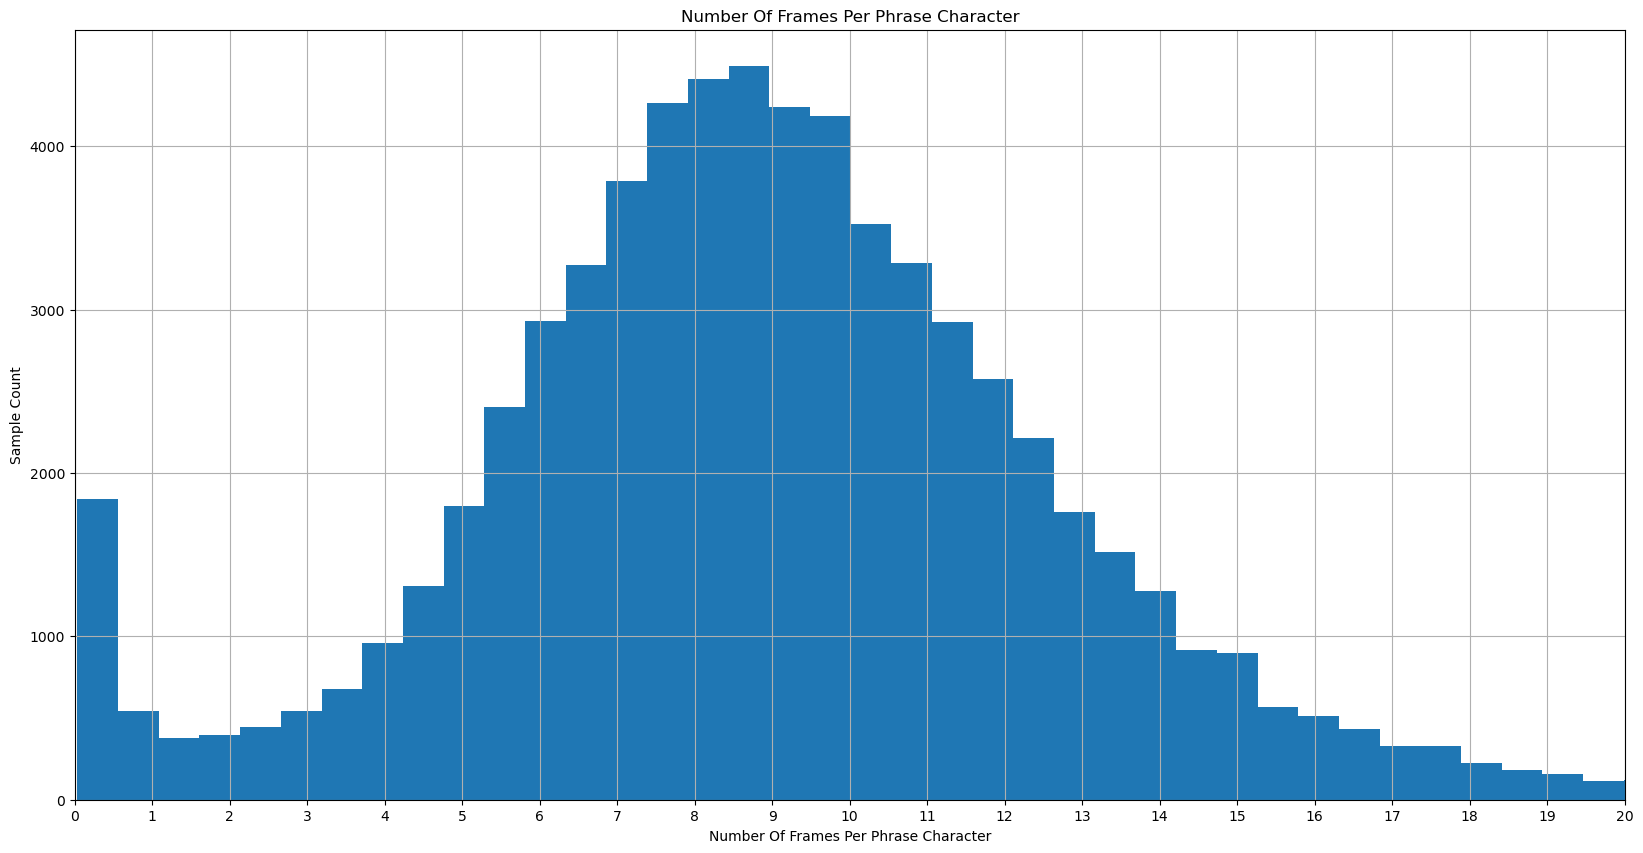

In [38]:
N_FRAMES_PER_CHARACTER_S = pd.Series(N_FRAMES_PER_CHARACTER)

plt.figure(figsize=(20,10))
plt.title('Number Of Frames Per Phrase Character')
N_FRAMES_PER_CHARACTER_S.plot(kind='hist', bins=128)
# Plot till 99th percentile
p99 = math.ceil(np.percentile(N_FRAMES_PER_CHARACTER_S, 99))
plt.xticks(np.arange(0, p99+1, 1))
plt.xlim(0, p99)
plt.xlabel('Number Of Frames Per Phrase Character')
plt.ylabel('Sample Count')
plt.grid()
plt.show()

# Dominant Hand Statistics

Calculamos la media y la desviación estándar de la mano dominante en los datos de entrada. Trazamos un boxplot para ver la distribución de los valores en las manos izquierda, derecha y los labios. Finalmente, guardamos las medias y las desviaciones estándar en archivos numpy para normalizar los datos de entrada en un modelo de red neuronal.

  0%|          | 0/164 [00:00<?, ?it/s]

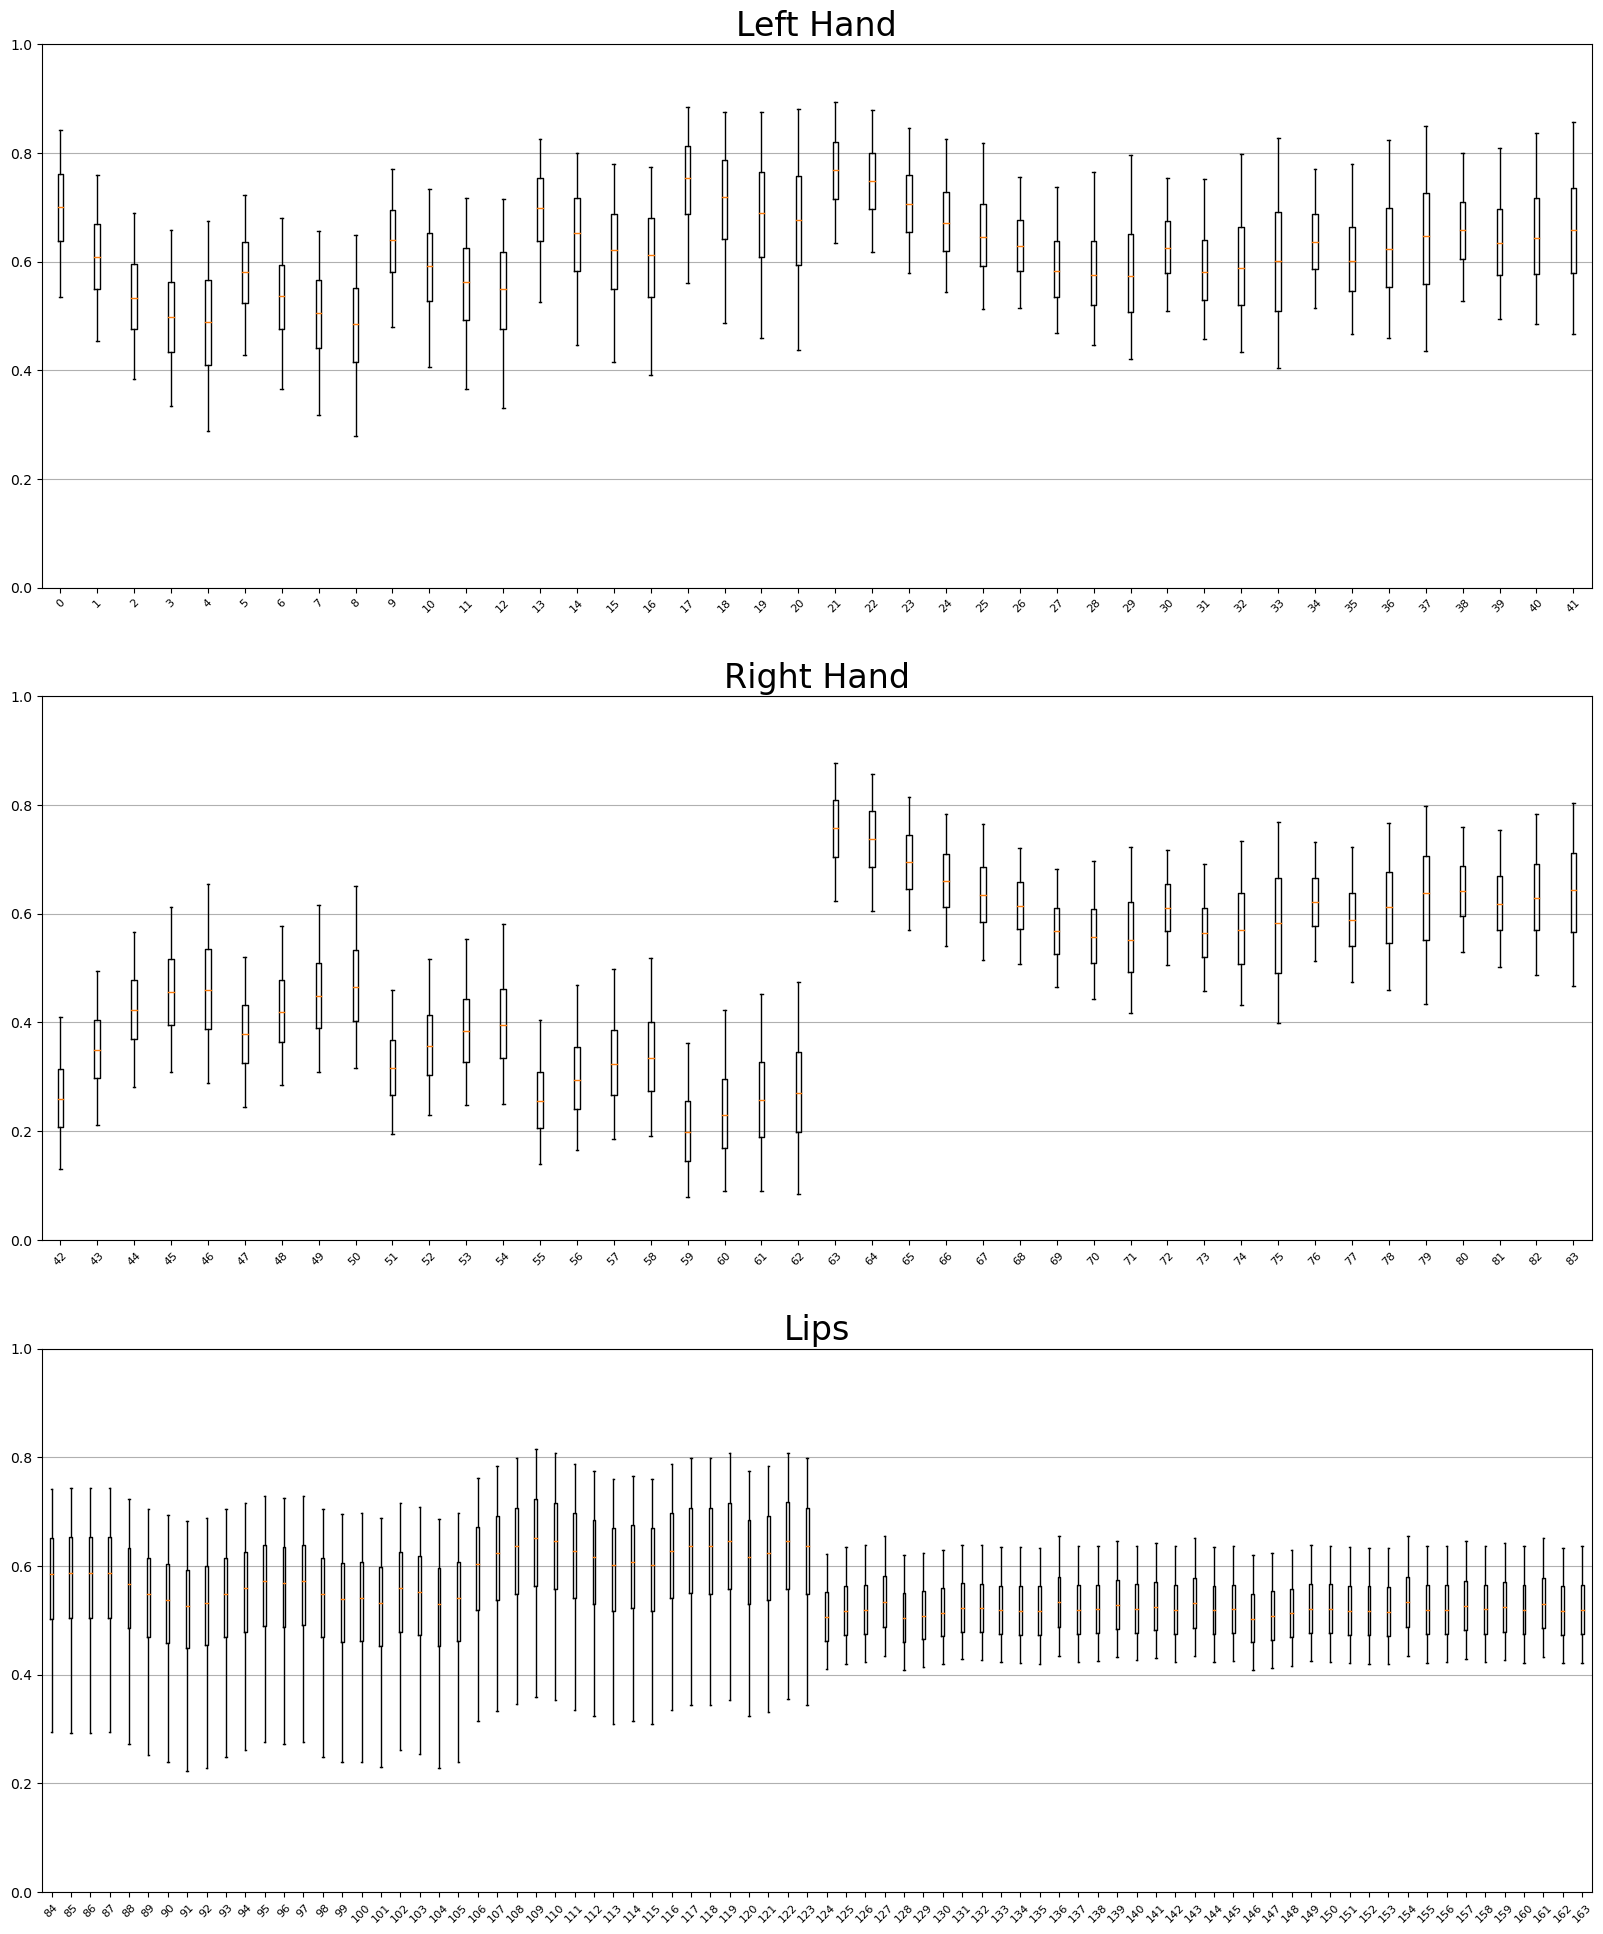

In [39]:
def get_left_right_hand_mean_std():
    # Dominant Hand Statistics
    MEANS = np.zeros([N_COLS], dtype=np.float32)
    STDS = np.zeros([N_COLS], dtype=np.float32)
    
    # Plot
    fig, axes = plt.subplots(3, figsize=(20, 3*8))
    
    # Iterate over all landmarks
    for col, v in enumerate(tqdm(X.reshape([-1, N_COLS]).T)):
        v = v[np.nonzero(v)]
        # Remove zero values as they are NaN values
        MEANS[col] = v.astype(np.float32).mean()
        STDS[col] = v.astype(np.float32).std()
        if col in LEFT_HAND_IDXS:
            axes[0].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        elif col in RIGHT_HAND_IDXS:
            axes[1].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        else:
            axes[2].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
    for ax, name in zip(axes, ['Left Hand', 'Right Hand', 'Lips']):
        ax.set_title(f'{name}', size=24)
        ax.tick_params(axis='x', labelsize=8, rotation=45)
        ax.set_ylim(0.0, 1.0)
        ax.grid(axis='y')

    plt.show()
    
    return MEANS, STDS

# Get Dominant Hand Mean/Standard Deviation
MEANS, STDS = get_left_right_hand_mean_std()
# Save Mean/STD to normalize input in neural network model
np.save('MEANS.npy', MEANS)
np.save('STDS.npy', STDS)